In [2]:
import torch
import torchvision
# from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),                         
    transforms.Normalize((0.1307), (0.3081,))            
])


train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
test_data  = datasets.MNIST('mnist_data', train=False, download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader  = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)




In [7]:
class Model(nn.Module):
    def __init__(self, in_vector = 28*28, h1 = 256, h2 = 128, num_calsses = 10):
        super().__init__() # instantiate our nn.Module
        self.fc1 = nn.Linear(in_vector, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, num_calsses) 

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [8]:
# Create an instance of model
model = Model()

In [5]:
# Set the criterion of model to the error
criterion = nn.CrossEntropyLoss()
# Choose optimizer, lr 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Train
epochs = 4
losses = []
for i in range(epochs):
    model.train()
    for images, labels in trainloader:
        
        output = model(images)
        
        # Measure the loss
        loss = criterion(output, labels)

        # Back ward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Keep track the losses
    losses.append(loss.detach().numpy())
    # Print every epoch
    print(f'{i+1}.) loss: {loss}')

1.) loss: 0.11130889505147934
2.) loss: 0.012710407376289368
3.) loss: 0.12874692678451538
4.) loss: 0.05471547320485115


In [7]:
torch.save(model.state_dict(), 'mnist_trained_pth')

In [9]:
model = Model()
model.load_state_dict(torch.load('mnist_trained_pth'))

<All keys matched successfully>

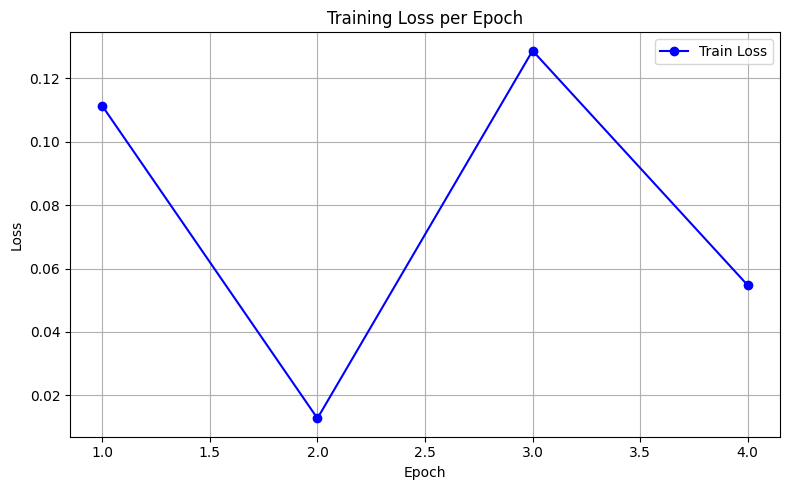

In [9]:
# 7. Plotting train loss per epoch
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), losses, marker='o', color='blue', label='Train Loss')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Evaluate model on test dataset 
model.eval()

correct = 0
total = 0

with torch.no_grad(): # Basically turn off the backpropagation
    for images, labels in testloader:
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

# Print the accuracy of model prediction
print(f"Test Accuracy: {correct} of {total} --> {100 * correct / total:.2f}%") 

Test Accuracy: 9750 of 10000 --> 97.50%


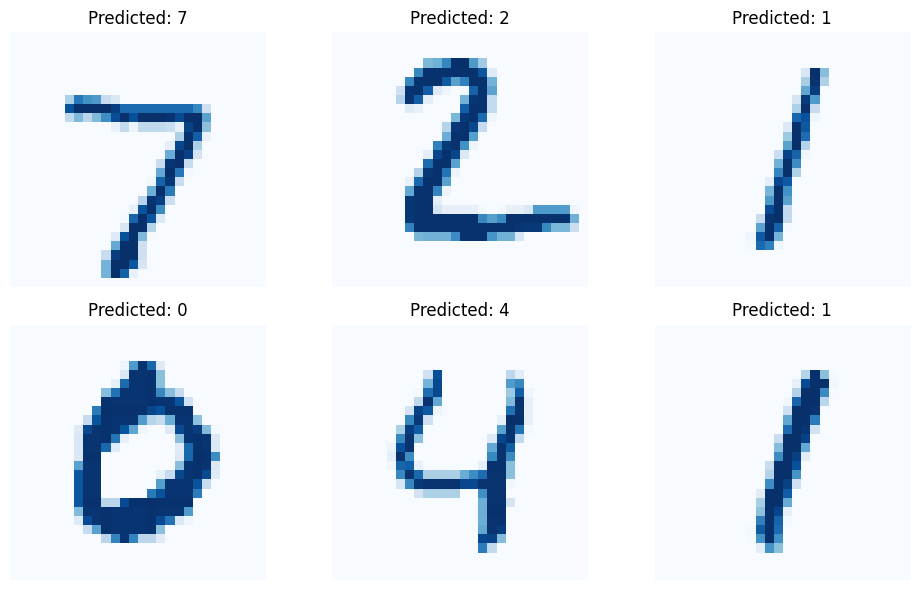

In [41]:
# Visualization
def predict(image):
    with torch.no_grad():
        output = model(image)
        _, predict = torch.max(output, 1)
        return predict.item()


fig, axs = plt.subplots(2, 3, figsize=(10, 6)) 
axs = axs.reshape(2, 3) 

for i in range(6):
    row, col = divmod(i, 3)  
    ax = axs[row, col]

    image_tensor, lebel = test_data[i]
    image = image_tensor.squeeze(0)
    ax.imshow(image, cmap='Blues')
    ax.set_title(f'Predicted: {predict(image_tensor)}')
    ax.axis('off')

plt.tight_layout()
plt.show()

'q' to send.


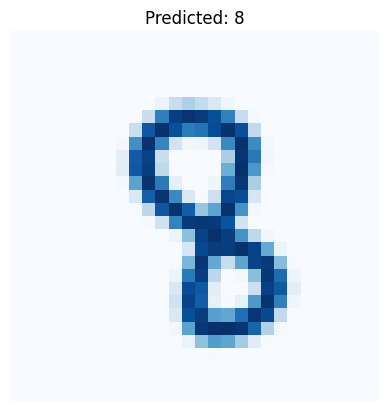

In [74]:
import numpy as np
import cv2
import torch

def draw_on_canvas(size=(512, 512)):
    canvas = np.zeros(size, dtype=np.uint8)
    drawing = False  

    def draw(event, x, y, flags, param):
        nonlocal drawing
        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
        elif event == cv2.EVENT_MOUSEMOVE and drawing:
            cv2.circle(canvas, (x, y), 19, (255,), -1)
        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False

    cv2.namedWindow('Draw')
    cv2.setMouseCallback('Draw', draw)

    print("'q' to send.")
    while True:
        cv2.imshow('Draw', canvas)
        key = cv2.waitKey(1)
        if key == ord('q'):
            break

    cv2.destroyAllWindows()

    tensor = torch.tensor(canvas, dtype=torch.float32) / 255.0 
    return tensor 


tensor_input = draw_on_canvas()

 
# Resize with torchvision
resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

tensor_input = resize(tensor_input.squeeze(0)) 

image = tensor_input.squeeze(0)

plt.imshow(image, cmap= "Blues")



# Now model should be predict the input
with torch.no_grad():
    pred = model(tensor_input)
    out = F.softmax(pred, dim=1).argmax().item()

plt.title(f'Predicted: {out}')
plt.axis("off")
plt.show()   